<a href="https://www.kaggle.com/code/atharvamuley25/densenet-brain-tumor-mri-classification?scriptVersionId=170527522" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import keras
import keras.backend as K
import cv2
import pandas as pd
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tqdm import tqdm
from IPython.display import SVG
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from time import time
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import tensorflow.keras.backend as K


2024-04-05 18:22:03.714947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-05 18:22:03.715087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-05 18:22:03.890793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 66.46it/s]


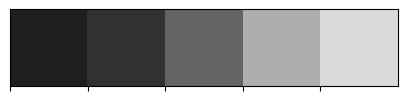

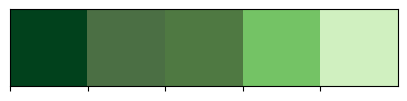

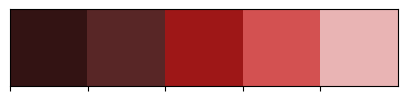

In [5]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

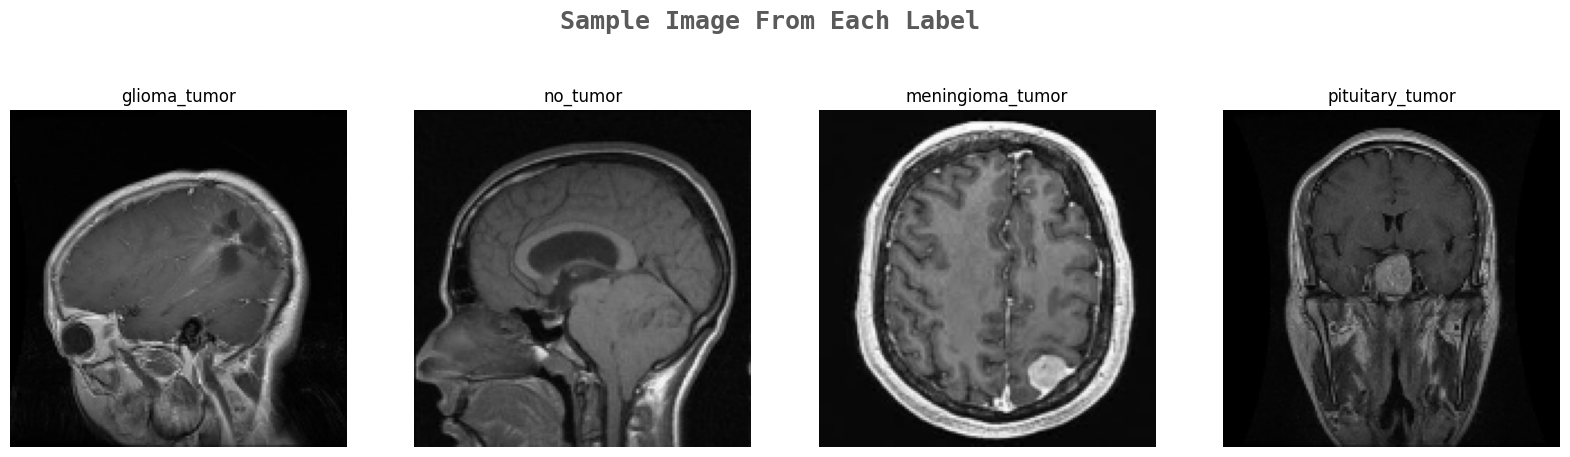

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

In [9]:
y_train.shape

(3264,)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
X_test.shape

(327, 150, 150, 3)

In [12]:
y_test.shape

(327,)

In [13]:
from sklearn.preprocessing import OneHotEncoder

# Initialize LabelEncoder
encoder = OneHotEncoder()

# Fit and transform labels
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

# Ensure that y_train_encoded has the shape (3264,)
print(y_train_encoded.shape)
print(y_test_encoded.shape)


(2937, 4)
(327, 4)


In [14]:
y_train.shape

(2937,)

In [15]:
def densenet(img_shape, n_classes, f=32):
    repetitions = 6, 12, 24, 16

    def bn_rl_conv(x, f, k=1, s=1, p='same'):
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(f, k, strides=s, padding=p)(x)
        return x

    def dense_block(tensor, r):
        for _ in range(r):
            x = bn_rl_conv(tensor, 4*f)
            x = bn_rl_conv(x, f, 3)
            tensor = Concatenate()([tensor, x])
        return tensor

    def transition_block(x):
        x = bn_rl_conv(x, K.int_shape(x)[-1] // 2)
        x = AvgPool2D(2, strides=2, padding='same')(x)
        return x

    input = Input(img_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(input)
    x = MaxPool2D(3, strides=2, padding='same')(x)

    for r in repetitions:
        d = dense_block(x, r)
        x = transition_block(d)

    x = GlobalAvgPool2D()(d)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model


In [16]:
# Define input shape and number of classes
img_shape = X_train.shape[1:]
n_classes = len(labels)

# Create DenseNet model
model = densenet(img_shape, n_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2)

# Evaluate the model on test data if available
# Replace X_test and y_test with your test data
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print('Test accuracy:', test_acc)

Epoch 1/50


I0000 00:00:1712341562.016420      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/74 ━━━━━━━━━━━━━━━━━━━━ 3:47:16 187s/step - accuracy: 0.1875 - loss: 1.9580

W0000 00:00:1712341562.225073      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4237 - loss: 2.2302   

W0000 00:00:1712341684.663057      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1712341695.617421      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.4245 - loss: 2.2219 - val_accuracy: 0.2789 - val_loss: 228.3429
Epoch 2/50


W0000 00:00:1712341709.049734      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 179ms/step - accuracy: 0.5789 - loss: 1.0383 - val_accuracy: 0.1548 - val_loss: 5.3386
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 180ms/step - accuracy: 0.6267 - loss: 0.8730 - val_accuracy: 0.5289 - val_loss: 1.2724
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 13s 181ms/step - accuracy: 0.6566 - loss: 0.8219 - val_accuracy: 0.1990 - val_loss: 5.8073
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.6806 - loss: 0.7976 - val_accuracy: 0.1582 - val_loss: 3.0858
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.6983 - loss: 0.7648 - val_accuracy: 0.5051 - val_loss: 1.7278
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.7785 - loss: 0.5898 - val_accuracy: 0.3384 - val_loss: 9.1779
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 0.7628 - loss: 0.6158 - val_accuracy: 0.4881 - val_loss: 3.0474
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.8002 - loss: 0.5379 - val_accuracy: 0.484

In [17]:
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print('Test accuracy:', test_acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8796 - loss: 0.7894
Test accuracy: 0.8776758313179016


W0000 00:00:1712342426.360118      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 75, 75,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 38, 38,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 38, 38,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 38, 38,    │      8,320 │ re_lu[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 38, 38,    │     36,896 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 38, 38,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 38, 38,    │     12,416 │ re_lu_2[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 38,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 38, 38,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 38, 38,    │     36,896 │ re_lu_3[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 38, 38,    │          0 │ concatenate[0][0

 Total params: 20,979,534 (80.03 MB)

 Trainable params: 6,966,020 (26.57 MB)

 Non-trainable params: 81,472 (318.25 KB)

 Optimizer params: 13,932,042 (53.15 MB)

In [19]:
def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()

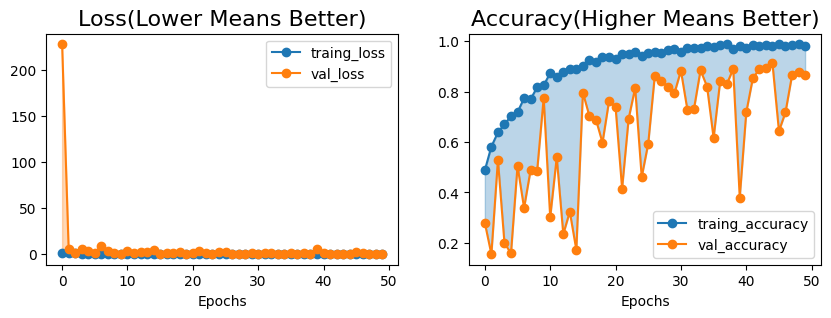

In [20]:
plot_training_curves(history)

In [21]:
xtest = X_test
ytest = y_test_encoded
ypred = model.predict(xtest)

total = len(ytest)
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
print('Total test data:', total)
print('Accurately predicted data:', accurate)
print('Wrongly predicted data:', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')


 5/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

W0000 00:00:1712342442.000109      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step
Total test data: 327
Accurately predicted data: 287
Wrongly predicted data: 40
Accuracy: 87.768 %


W0000 00:00:1712342452.642238      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


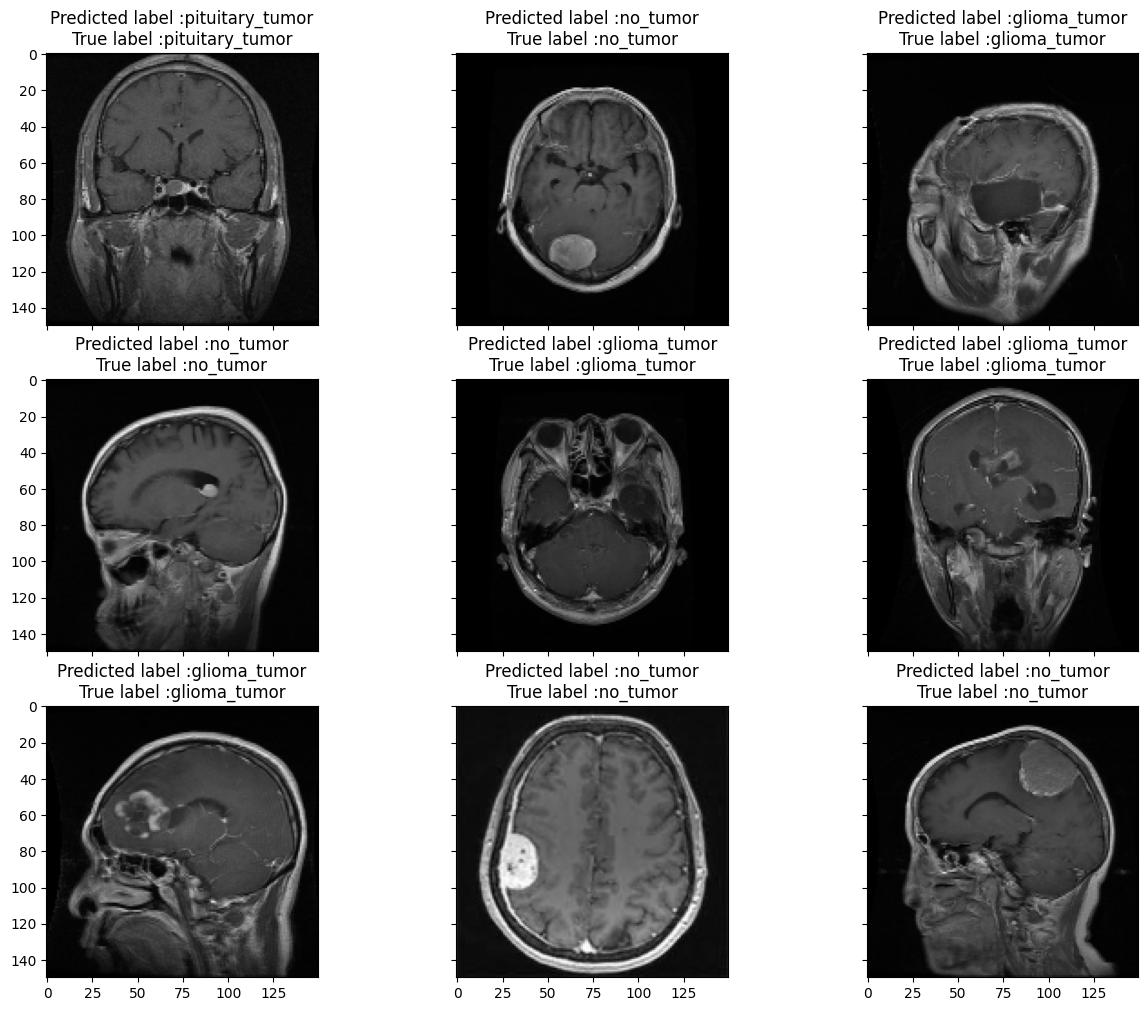

In [22]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

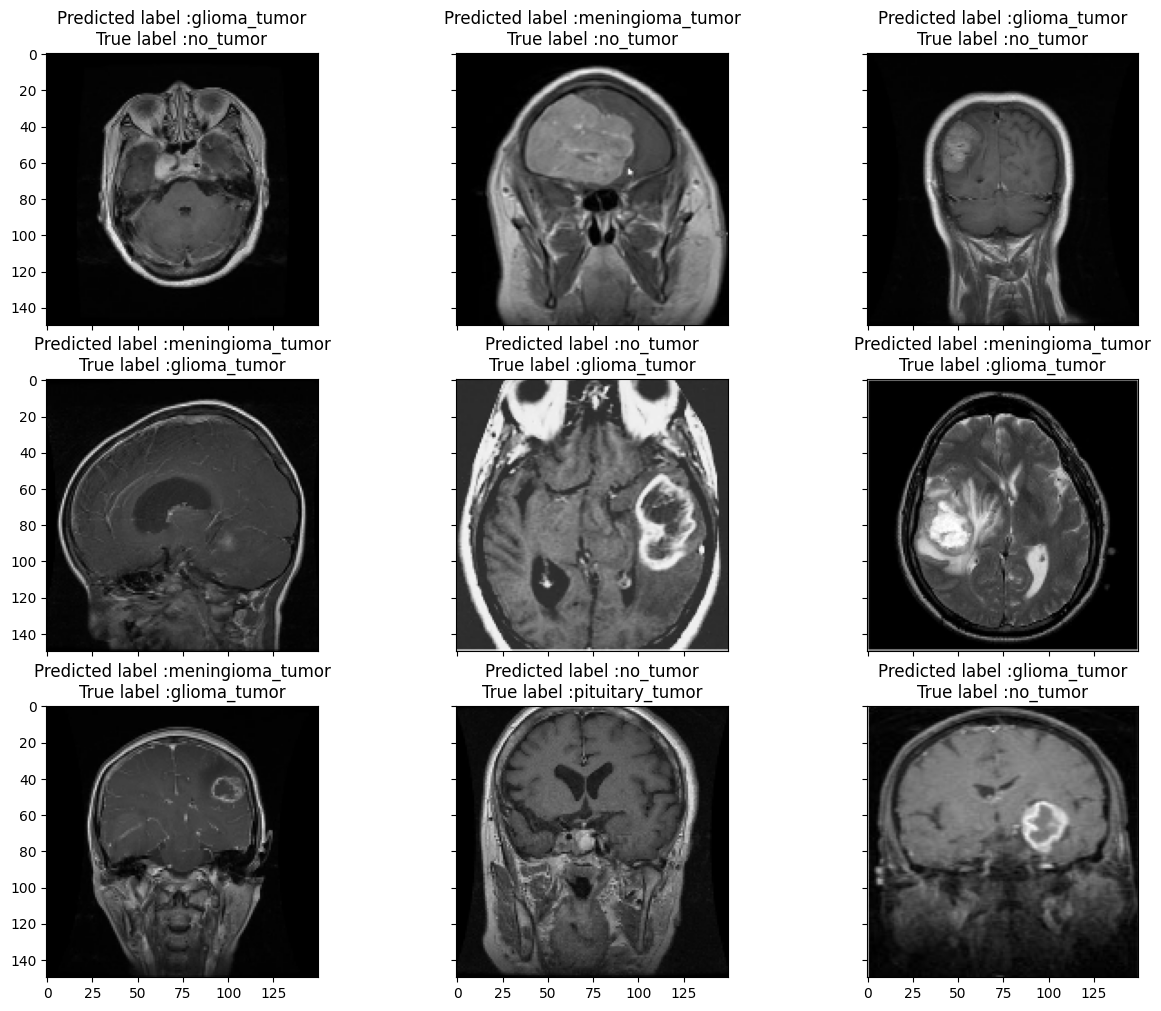

In [23]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(wrongindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()